# Data Science Project: Fuel Price Prediction Model

### 3-Sentence summary of full project:

We build a route-aware refueling recommender for Germany that forecasts station-level prices at the ETA and then optimizes “where/when to stop (and how much to buy)” by trading cheaper price vs. detour/time and fuel constraints. The pipeline ingests historical + live data, enriches with routing/ETA, weather, holidays, and macro signals, and serves uncertainty-aware recommendations via a FastAPI backend and an interactive Streamlit map. Everything is fully automated, validated, and documented in a reproducible repo, with the app hosted on the bwCloud.

## Data Preparation

In [1]:
import duckdb
from pathlib import Path

# Base directory of the cloned tankerkoenig-data repo
BASE_DIR = Path(
    r"C:\Users\websi\OneDrive - UT Cloud\Semester\3. WS2025_26\DS500 Data Science Project (12 ECTS)\tankerkoenig_repo\tankerkoenig-data"
)

# DuckDB database file (will be created if it does not exist)
DB_PATH = BASE_DIR / "fuel_price_preparation.duckdb"

con = duckdb.connect(DB_PATH.as_posix())
con.execute("PRAGMA threads=8;")  # use multiple cores if available

print(f"Connected to DuckDB at: {DB_PATH}")

Connected to DuckDB at: C:\Users\websi\OneDrive - UT Cloud\Semester\3. WS2025_26\DS500 Data Science Project (12 ECTS)\tankerkoenig_repo\tankerkoenig-data\fuel_price_preparation.duckdb


In [2]:
# Globs for 2023/2024 prices and stations
prices_2023_glob = (BASE_DIR / "prices" / "2023" / "*" / "*-prices.csv").as_posix()
prices_2024_glob = (BASE_DIR / "prices" / "2024" / "*" / "*-prices.csv").as_posix()

stations_2023_glob = (BASE_DIR / "stations" / "2023" / "*" / "*-stations.csv").as_posix()
stations_2024_glob = (BASE_DIR / "stations" / "2024" / "*" / "*-stations.csv").as_posix()

print(prices_2023_glob)
print(prices_2024_glob)
print(stations_2023_glob)
print(stations_2024_glob)

C:/Users/websi/OneDrive - UT Cloud/Semester/3. WS2025_26/DS500 Data Science Project (12 ECTS)/tankerkoenig_repo/tankerkoenig-data/prices/2023/*/*-prices.csv
C:/Users/websi/OneDrive - UT Cloud/Semester/3. WS2025_26/DS500 Data Science Project (12 ECTS)/tankerkoenig_repo/tankerkoenig-data/prices/2024/*/*-prices.csv
C:/Users/websi/OneDrive - UT Cloud/Semester/3. WS2025_26/DS500 Data Science Project (12 ECTS)/tankerkoenig_repo/tankerkoenig-data/stations/2023/*/*-stations.csv
C:/Users/websi/OneDrive - UT Cloud/Semester/3. WS2025_26/DS500 Data Science Project (12 ECTS)/tankerkoenig_repo/tankerkoenig-data/stations/2024/*/*-stations.csv


In [3]:
# 2.1 Prices: read 2023 + 2024 into one table
con.execute("DROP TABLE IF EXISTS prices_raw;")
con.execute(
    """
    CREATE TABLE prices_raw AS
    SELECT * FROM read_csv_auto(?, SAMPLE_SIZE=-1)
    UNION ALL
    SELECT * FROM read_csv_auto(?, SAMPLE_SIZE=-1);
    """,
    [prices_2023_glob, prices_2024_glob],
)

# Quick sanity check
con.execute("SELECT COUNT(*) AS n_rows, MIN(date), MAX(date) FROM prices_raw;").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,min(date),max(date)
0,273916339,2022-12-31 23:00:10,2024-12-31 22:59:28


In [4]:
# 2.2 Stations: read 2023 + 2024 into one table, also keep filename
con.execute("DROP TABLE IF EXISTS stations_raw;")
con.execute(
    """
    CREATE TABLE stations_raw AS
    SELECT
        uuid,
        name,
        brand,
        street,
        house_number,
        post_code,
        city,
        latitude,
        longitude,
        first_active,
        openingtimes_json,
        filename
    FROM read_csv_auto(
            ?, 
            SAMPLE_SIZE=-1, 
            filename=true, 
            union_by_name=true
         )
    UNION ALL
    SELECT
        uuid,
        name,
        brand,
        street,
        house_number,
        post_code,
        city,
        latitude,
        longitude,
        first_active,
        openingtimes_json,
        filename
    FROM read_csv_auto(
            ?, 
            SAMPLE_SIZE=-1, 
            filename=true, 
            union_by_name=true
         );
    """,
    [stations_2023_glob, stations_2024_glob],
)

con.execute(
    "SELECT COUNT(*) AS n_rows, MIN(uuid) AS min_uuid, MAX(uuid) AS max_uuid FROM stations_raw;"
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,min_uuid,max_uuid
0,12523064,00000000-0000-0000-0000-000000009011,fffd3828-c4e3-1035-8eef-40618651be9a


In [5]:
# 3.1 Pick latest snapshot per station within 2023–2024
con.execute("DROP TABLE IF EXISTS stations_snapshot;")
con.execute(
    """
    CREATE TABLE stations_snapshot AS
    WITH parsed AS (
        SELECT
            *,
            -- extract 'YYYY-MM-DD' from filename, e.g. '.../2023-01-01-stations.csv'
            CAST(regexp_extract(filename, '([0-9]{4}-[0-9]{2}-[0-9]{2})', 1) AS DATE) AS snapshot_date
        FROM stations_raw
    ),
    ranked AS (
        SELECT
            *,
            ROW_NUMBER() OVER (PARTITION BY uuid ORDER BY snapshot_date DESC) AS rn
        FROM parsed
    )
    SELECT
        uuid,
        name,
        brand,
        street,
        house_number,
        post_code,
        city,
        CAST(latitude AS DOUBLE)  AS latitude,
        CAST(longitude AS DOUBLE) AS longitude,
        first_active,
        openingtimes_json
    FROM ranked
    WHERE rn = 1;
    """
)

con.execute(
    "SELECT COUNT(*) AS n_rows, COUNT(DISTINCT uuid) AS n_uuids FROM stations_snapshot;"
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,n_uuids
0,17444,17444


In [42]:
# 3.2 Restrict to Berlin stations and compute brand groups (rare brands -> 'other')
con.execute("DROP TABLE IF EXISTS stations_berlin;")
con.execute(
    """
    CREATE TABLE stations_berlin AS
    SELECT
        uuid,
        brand,
        post_code,
        city
    FROM stations_snapshot
    WHERE lower(city) = 'berlin';
    """
)

# Brand grouping: brands with < 5 stations in Berlin are mapped to 'other'
con.execute("DROP TABLE IF EXISTS stations_berlin_grouped;")
con.execute(
    """
    CREATE TABLE stations_berlin_grouped AS
    WITH brand_counts AS (
        SELECT brand, COUNT(*) AS n
        FROM stations_berlin
        GROUP BY brand
    ),
    extended AS (
        SELECT
            s.uuid,
            s.post_code,
            s.city,
            CASE WHEN bc.n >= 5 THEN s.brand ELSE 'other' END AS brand_group
        FROM stations_berlin s
        LEFT JOIN brand_counts bc USING (brand)
    )
    SELECT * FROM extended;
    """
)

con.execute(
    "SELECT brand_group, COUNT(*) AS n_stations FROM stations_berlin_grouped GROUP BY brand_group ORDER BY n_stations DESC;"
).df()

,brand_group,n_stations
0,ARAL,60
1,Shell,48
2,other,36
3,TotalEnergies,35
4,STAR,28
5,ESSO,26
6,JET,22
7,Sprint,20
8,HEM,18
9,AGIP ENI,7


In [43]:
# 4.1 Berlin E5 price changes
con.execute("DROP TABLE IF EXISTS prices_berlin_e5;")
con.execute(
    """
    CREATE TABLE prices_berlin_e5 AS
    SELECT
        CAST(p.date AS TIMESTAMP) AS ts,
        p.station_uuid,
        CAST(p.e5 AS DOUBLE) AS price_e5
    FROM prices_raw p
    JOIN stations_berlin_grouped s
      ON s.uuid = p.station_uuid
    WHERE p.e5 IS NOT NULL AND p.e5 > 0;
    """
)

con.execute(
    "SELECT COUNT(*) AS n_rows, MIN(ts) AS min_ts, MAX(ts) AS max_ts FROM prices_berlin_e5;"
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,min_ts,max_ts
0,5914122,2022-12-31 23:02:08,2024-12-31 22:41:11


In [44]:
# 4.2 Round timestamps down to the nearest 30-minute grid cell
con.execute("DROP TABLE IF EXISTS prices_berlin_e5_rounded;")
con.execute(
    """
    CREATE TABLE prices_berlin_e5_rounded AS
    SELECT
        station_uuid,
        -- floor to 30-minute grid: 00 or 30
        date_trunc('hour', ts)
          + INTERVAL (CASE WHEN EXTRACT(MINUTE FROM ts) < 30 THEN 0 ELSE 30 END) MINUTE AS ts_30,
        AVG(price_e5) AS price_e5
    FROM prices_berlin_e5
    GROUP BY station_uuid, ts_30;
    """
)

con.execute(
    "SELECT COUNT(*) AS n_rows, MIN(ts_30) AS min_ts, MAX(ts_30) AS max_ts FROM prices_berlin_e5_rounded;"
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,min_ts,max_ts
0,4136826,2022-12-31 23:00:00,2024-12-31 22:30:00


In [45]:
con.execute("DROP TABLE IF EXISTS grid_berlin_e5;")
con.execute(
    """
    CREATE TABLE grid_berlin_e5 AS
    WITH station_span AS (
        SELECT
            station_uuid,
            MIN(ts_30) AS min_ts,
            MAX(ts_30) AS max_ts
        FROM prices_berlin_e5_rounded
        GROUP BY station_uuid
    ),
    grid AS (
        -- 30-minute grid per station from first to last observed change
        SELECT
            s.station_uuid,
            gs.ts_30
        FROM station_span s,
             generate_series(
                 s.min_ts,
                 s.max_ts,
                 INTERVAL 30 MINUTE
             ) AS gs(ts_30)
    ),
    base AS (
        -- attach price events (may be NULL if no change in this grid cell)
        SELECT
            g.station_uuid,
            g.ts_30,
            pr.price_e5 AS price_event
        FROM grid g
        LEFT JOIN prices_berlin_e5_rounded pr
          ON pr.station_uuid = g.station_uuid
         AND pr.ts_30 = g.ts_30
    ),
    numbered AS (
        -- sequential index per station for forward-fill logic
        SELECT
            station_uuid,
            ts_30,
            price_event,
            ROW_NUMBER() OVER (PARTITION BY station_uuid ORDER BY ts_30) AS k
        FROM base
    ),
    with_last_k AS (
        -- for each row, compute index of last row with a non-null price_event
        SELECT
            station_uuid,
            ts_30,
            k,
            MAX(CASE WHEN price_event IS NOT NULL THEN k ELSE NULL END) OVER (
                PARTITION BY station_uuid
                ORDER BY k
                ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
            ) AS last_k
        FROM numbered
    ),
    ff AS (
        -- join back to get the forward-filled price
        SELECT
            n.station_uuid,
            n.ts_30,
            e.price_event AS price_e5
        FROM with_last_k n
        LEFT JOIN numbered e
          ON e.station_uuid = n.station_uuid
         AND e.k = n.last_k
    )
    SELECT *
    FROM ff
    WHERE price_e5 IS NOT NULL;
    """
)

con.execute(
    "SELECT COUNT(*) AS n_rows, MIN(ts_30) AS min_ts, MAX(ts_30) AS max_ts FROM grid_berlin_e5;"
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,min_ts,max_ts
0,9533461,2022-12-31 23:00:00,2024-12-31 22:30:00


In [46]:
con.execute("DROP TABLE IF EXISTS grid_berlin_e5_prepared;")
con.execute(
    """
    CREATE TABLE grid_berlin_e5_prepared AS
    SELECT
        station_uuid,
        ts_30 AS ts,
        CAST(ts_30 AS DATE) AS d,                                  -- calendar date
        (EXTRACT(HOUR FROM ts_30) * 2 + EXTRACT(MINUTE FROM ts_30) / 30) AS time_cell,  -- 0..47
        price_e5 AS price
    FROM grid_berlin_e5;
    """
)

con.execute(
    """
    SELECT
        MIN(d) AS min_date,
        MAX(d) AS max_date,
        MIN(time_cell) AS min_cell,
        MAX(time_cell) AS max_cell
    FROM grid_berlin_e5_prepared;
    """
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,min_date,max_date,min_cell,max_cell
0,2022-12-31,2024-12-31,0.0,47.0


In [47]:
con.execute("DROP TABLE IF EXISTS features_raw;")
con.execute(
    """
    CREATE TABLE features_raw AS
    SELECT
        g.station_uuid,
        g.d,
        g.time_cell,
        g.price AS price_today,
        y.price AS price_yesterday,
        w.price AS price_weekago
    FROM grid_berlin_e5_prepared g
    LEFT JOIN grid_berlin_e5_prepared y
      ON y.station_uuid = g.station_uuid
     AND y.time_cell   = g.time_cell
     AND y.d           = g.d - INTERVAL 1 DAY
    LEFT JOIN grid_berlin_e5_prepared w
      ON w.station_uuid = g.station_uuid
     AND w.time_cell   = g.time_cell
     AND w.d           = g.d - INTERVAL 7 DAY;
    """
)

con.execute(
    """
    SELECT
        COUNT(*) AS n_rows,
        SUM(CASE WHEN price_yesterday IS NOT NULL AND price_weekago IS NOT NULL THEN 1 ELSE 0 END) AS n_complete
    FROM features_raw;
    """
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,n_complete
0,9533461,9440387.0


In [80]:
con.execute("DROP TABLE IF EXISTS features_berlin_e5;")
con.execute(
    """
    CREATE TABLE features_berlin_e5 AS
    SELECT
        f.station_uuid,
        f.d      AS date,
        f.time_cell,
        f.price_today    AS price,
        f.price_yesterday,
        f.price_weekago,
        sb.brand_group,
        sb.post_code,
        EXTRACT(DOW FROM f.d) AS day_of_week  -- 0=Sunday ... 6=Saturday
    FROM features_raw f
    JOIN stations_berlin_grouped sb
      ON sb.uuid = f.station_uuid
    WHERE f.price_yesterday IS NOT NULL
      AND f.price_weekago  IS NOT NULL;
    """
)

con.execute(
    """
    SELECT
        COUNT(*) AS n_rows,
        MIN(date) AS min_date,
        MAX(date) AS max_date
    FROM features_berlin_e5;
    """
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,min_date,max_date
0,9440387,2023-01-07,2024-12-31


In [81]:
sample_df = con.execute(
    "SELECT * FROM features_berlin_e5 ORDER BY date, time_cell, station_uuid LIMIT 20;"
).df()
sample_df

,station_uuid,date,time_cell,price,price_yesterday,price_weekago,brand_group,post_code,day_of_week
0,0ab14657-b01e-4827-a5d4-311ad444b887,2023-01-07,46.0,1.749,1.749,1.819,other,13467,6
1,b7ccde58-35f9-42c0-8ce7-31185d7275fe,2023-01-07,46.0,2.319,2.319,2.319,ARAL,14129,6
2,0ab14657-b01e-4827-a5d4-311ad444b887,2023-01-07,47.0,1.749,1.749,1.819,other,13467,6
3,2621d571-e8f3-40c6-881f-b9fd3415ed9e,2023-01-07,47.0,1.769,1.769,1.799,TotalEnergies,13403,6
4,285aaf2a-f363-4c83-9fd2-4c9cc34833b2,2023-01-07,47.0,1.759,1.739,1.799,TotalEnergies,13051,6
5,38e0e779-b0f1-46ae-a35b-09f8e37024a1,2023-01-07,47.0,1.779,1.779,1.799,TotalEnergies,10369,6
6,403be9a4-04fb-4bd0-9b52-ca1cfb8490c5,2023-01-07,47.0,1.739,1.739,1.799,TotalEnergies,12527,6
7,474e5046-deaf-4f9b-9a32-9797b778f047,2023-01-07,47.0,1.779,1.779,1.799,TotalEnergies,10407,6
8,51863198-2987-48b8-aa2e-dd949bc403dc,2023-01-07,47.0,1.739,1.739,1.799,TotalEnergies,12435,6
9,5b24dba1-c64c-4480-9943-ac3f23e43912,2023-01-07,47.0,1.779,1.779,1.799,TotalEnergies,10963,6


In [82]:
# --- 3.x Load EU Weekly Oil Bulletin (market-level prices) into DuckDB ---

market_csv = BASE_DIR / "market_level_fuel_price.csv"  # adjust name if needed

con.execute("DROP TABLE IF EXISTS market_weekly;")
con.execute(
    """
    CREATE TABLE market_weekly AS
    SELECT
        -- 'date' is already a DATE from read_csv_auto
        CAST(date AS DATE)          AS date,
        CAST(euro95_1000l AS DOUBLE) AS euro95_1000l,
        CAST(diesel_1000l AS DOUBLE) AS diesel_1000l
    FROM read_csv_auto(?, SAMPLE_SIZE=-1);
    """,
    [market_csv.as_posix()],
)

# Quick check
con.execute(
    "SELECT MIN(date) AS min_date, MAX(date) AS max_date, COUNT(*) AS n_rows FROM market_weekly;"
).df()


,min_date,max_date,n_rows
0,2001-01-24,2031-10-22,201


In [83]:
# --- 3.x Create daily Euro95 market index + lagged versions ---

# 1) Daily series with forward-filled weekly values
con.execute("DROP TABLE IF EXISTS market_daily;")
con.execute(
    """
    CREATE TABLE market_daily AS
    WITH days AS (
        -- generate one row per calendar day between first and last bulletin
        SELECT
            gs AS date
        FROM generate_series(
            (SELECT MIN(date) FROM market_weekly),
            (SELECT MAX(date) FROM market_weekly),
            INTERVAL 1 DAY
        ) AS t(gs)
    ),
    joined AS (
        -- join weekly quotes onto the daily calendar
        SELECT
            d.date,
            w.euro95_1000l
        FROM days d
        LEFT JOIN market_weekly w
          ON w.date = d.date
    ),
    grp AS (
        -- running count of non-null quotes; constant within each bulletin interval
        SELECT
            date,
            euro95_1000l,
            COUNT(CASE WHEN euro95_1000l IS NOT NULL THEN 1 END)
                OVER (ORDER BY date) AS grp
        FROM joined
    ),
    ff AS (
        -- forward-filled value: within each grp use the (only) non-null quote
        SELECT
            date,
            MAX(euro95_1000l) OVER (PARTITION BY grp) AS euro95_1000l
        FROM grp
    )
    SELECT *
    FROM ff
    ORDER BY date;
    """
)

# sanity check
con.execute(
    "SELECT MIN(date) AS min_date, MAX(date) AS max_date, COUNT(*) AS n_rows FROM market_daily;"
).df()

# 2) Add daily lags: market_yesterday (1 day), market_weekago (7 days)
con.execute("DROP TABLE IF EXISTS market_daily_lags;")
con.execute(
    """
    CREATE TABLE market_daily_lags AS
    SELECT
        date,
        euro95_1000l,
        lag(euro95_1000l, 1) OVER (ORDER BY date) AS market_yesterday,
        lag(euro95_1000l, 7) OVER (ORDER BY date) AS market_weekago
    FROM market_daily
    ORDER BY date;
    """
)

con.execute(
    "SELECT * FROM market_daily_lags ORDER BY date LIMIT 10;"
).df()

,date,euro95_1000l,market_yesterday,market_weekago
0,2001-01-24,1784.0,NaN,NaN
1,2001-01-25,1784.0,1784.0,NaN
2,2001-01-26,1784.0,1784.0,NaN
3,2001-01-27,1784.0,1784.0,NaN
4,2001-01-28,1784.0,1784.0,NaN
5,2001-01-29,1784.0,1784.0,NaN
6,2001-01-30,1784.0,1784.0,NaN
7,2001-01-31,1784.0,1784.0,1784.0
8,2001-02-01,1784.0,1784.0,1784.0
9,2001-02-02,1784.0,1784.0,1784.0


In [84]:
# --- 3.x Enrich features_berlin_e5 with market-level variables and markups ---

con.execute("DROP TABLE IF EXISTS features_berlin_e5_market;")
con.execute(
    """
    CREATE TABLE features_berlin_e5_market AS
    SELECT
        f.station_uuid,
        f.date,
        f.time_cell,
        f.price,
        f.price_yesterday,
        f.price_weekago,
        f.brand_group,
        f.post_code,
        f.day_of_week,
        m.market_yesterday,
        m.market_weekago,
        -- ECM-style markup terms (station price minus market level)
        f.price_yesterday - m.market_yesterday AS markup_yesterday,
        f.price_weekago  - m.market_weekago  AS markup_weekago
    FROM features_berlin_e5 f
    LEFT JOIN market_daily_lags m
      ON f.date = m.date
    WHERE m.market_yesterday IS NOT NULL
      AND m.market_weekago IS NOT NULL
    ;
    """
)

# Sanity check
con.execute(
    """
    SELECT COUNT(*) AS n_rows,
           MIN(date) AS min_date,
           MAX(date) AS max_date
    FROM features_berlin_e5_market;
    """
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,min_date,max_date
0,9440387,2023-01-07,2024-12-31


In [60]:
# --- 3.x Export enriched features (with market) to Parquet ---

output_dir = BASE_DIR / "derived"
output_dir.mkdir(exist_ok=True)

output_parquet = output_dir / "features_berlin_e5_market_2023_2024.parquet"

sql = f"""
COPY features_berlin_e5_market
TO '{output_parquet.as_posix()}'
(FORMAT PARQUET, COMPRESSION ZSTD);
"""
con.execute(sql)

print(f"Exported features with market to: {output_parquet}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Exported features with market to: C:\Users\websi\OneDrive - UT Cloud\Semester\3. WS2025_26\DS500 Data Science Project (12 ECTS)\tankerkoenig_repo\tankerkoenig-data\derived\features_berlin_e5_market_2023_2024.parquet


## Model training

In [86]:
import pandas as pd
import numpy as np
from pathlib import Path

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Path to enriched features parquet
BASE_DIR = Path(
    r"C:\Users\websi\OneDrive - UT Cloud\Semester\3. WS2025_26\DS500 Data Science Project (12 ECTS)\tankerkoenig_repo\tankerkoenig-data"
)
features_path = BASE_DIR / "derived" / "features_berlin_e5_market_2023_2024.parquet"

df = pd.read_parquet(features_path)
print(df.shape)
df.head()

(9440387, 16)


,station_uuid,date,time_cell,price,price_intraday_prev,price_intraday_prev2,price_intraday_prev3,price_yesterday,price_weekago,brand_group,post_code,day_of_week,market_yesterday,market_weekago,markup_yesterday,markup_weekago
0,f521427a-e115-4664-ad12-f8ae37f5b001,2023-07-18,6.0,1.859,1.805667,1.805667,1.805667,1.859,1.879,Shell,13129,2,1760.0,1760.0,-1758.141,-1758.121
1,f521427a-e115-4664-ad12-f8ae37f5b001,2023-07-18,7.0,1.859,1.859000,1.805667,1.805667,1.859,1.869,Shell,13129,2,1760.0,1760.0,-1758.141,-1758.131
2,f521427a-e115-4664-ad12-f8ae37f5b001,2023-07-18,8.0,1.849,1.859000,1.859000,1.805667,1.849,1.849,Shell,13129,2,1760.0,1760.0,-1758.151,-1758.151
3,f521427a-e115-4664-ad12-f8ae37f5b001,2023-07-18,9.0,1.849,1.849000,1.859000,1.859000,1.849,1.849,Shell,13129,2,1760.0,1760.0,-1758.151,-1758.151
4,f521427a-e115-4664-ad12-f8ae37f5b001,2023-07-18,10.0,1.849,1.849000,1.849000,1.859000,1.849,1.849,Shell,13129,2,1760.0,1760.0,-1758.151,-1758.151


In [87]:
# Cast dtypes for clarity / efficiency
df["date"] = pd.to_datetime(df["date"])
df["time_cell"] = df["time_cell"].astype("int16")
df["day_of_week"] = df["day_of_week"].astype("int8")
df["post_code"] = df["post_code"].astype(str)

# Optional: sort by time (not strictly needed but nice to have)
df = df.sort_values(["date", "time_cell", "station_uuid"]).reset_index(drop=True)

df.dtypes

station_uuid                    object
date                    datetime64[ns]
time_cell                        int16
price                          float64
price_intraday_prev            float64
price_intraday_prev2           float64
price_intraday_prev3           float64
price_yesterday                float64
price_weekago                  float64
brand_group                     object
post_code                       object
day_of_week                       int8
market_yesterday               float64
market_weekago                 float64
markup_yesterday               float64
markup_weekago                 float64
dtype: object

In [88]:
# --- NEW: intraday last-price feature (per station & day) ---

# make sure rows are ordered correctly
df = df.sort_values(["station_uuid", "date", "time_cell"]).reset_index(drop=True)

# price in the *previous* time cell on the same day for the same station
df["price_intraday_prev"] = (
    df
    .groupby(["station_uuid", "date"])["price"]
    .shift(1)
)

# simple and safe missing-value handling:
# for the first time_cell of each day there is no "previous cell"
# -> fall back to yesterday's price at this time_cell
df["price_intraday_prev"] = df["price_intraday_prev"].fillna(df["price_yesterday"])

# optional: ensure numeric type consistent with other price features
df["price_intraday_prev"] = df["price_intraday_prev"].astype("float32")

In [89]:
# Define cut dates
train_end = pd.Timestamp("2024-06-30")
valid_end = pd.Timestamp("2024-09-30")

train_mask = df["date"] <= train_end
valid_mask = (df["date"] > train_end) & (df["date"] <= valid_end)
test_mask  = df["date"] > valid_end

print("Train rows:", train_mask.sum())
print("Valid rows:", valid_mask.sum())
print("Test rows :", test_mask.sum())

Train rows: 7062549
Valid rows: 1192320
Test rows : 1185518


In [90]:
# --- Define target and features ---

target_col = "price"

feature_cols = [
    "time_cell",
    "day_of_week",
    "post_code",
    "brand_group",
    "price_intraday_prev",   # NEW: intraday last price (same day, same station)
    "price_yesterday",
    "price_weekago",
    "market_yesterday",
    "market_weekago",
    "markup_yesterday",
    "markup_weekago",
]

cat_cols = ["brand_group", "post_code"]  # categorical for LightGBM

# --- Time-based train/validation/test split (as before) ---

train_end = pd.Timestamp("2024-06-30")
valid_end = pd.Timestamp("2024-09-30")

train_mask = df["date"] <= train_end
valid_mask = (df["date"] > train_end) & (df["date"] <= valid_end)
test_mask  = df["date"] > valid_end

print("Train rows:", train_mask.sum())
print("Valid rows:", valid_mask.sum())
print("Test rows :", test_mask.sum())

X_train = df.loc[train_mask, feature_cols].copy()
y_train = df.loc[train_mask, target_col].values

X_valid = df.loc[valid_mask, feature_cols].copy()
y_valid = df.loc[valid_mask, target_col].values

X_test  = df.loc[test_mask,  feature_cols].copy()
y_test  = df.loc[test_mask,  target_col].values

# Cast categoricals
for c in cat_cols:
    X_train[c] = X_train[c].astype("category")
    X_valid[c] = X_valid[c].astype("category")
    X_test[c]  = X_test[c].astype("category")

X_train.head()

Train rows: 7062549
Valid rows: 1192320
Test rows : 1185518


,time_cell,day_of_week,post_code,brand_group,price_intraday_prev,price_yesterday,price_weekago,market_yesterday,market_weekago,markup_yesterday,markup_weekago
0,9,0,12107,other,1.779,1.779,1.799,1715.0,1715.0,-1713.221,-1713.201
1,10,0,12107,other,1.779,1.779,1.799,1715.0,1715.0,-1713.221,-1713.201
2,11,0,12107,other,1.779,1.879,1.869,1715.0,1715.0,-1713.121,-1713.131
3,12,0,12107,other,1.879,1.879,1.869,1715.0,1715.0,-1713.121,-1713.131
4,13,0,12107,other,1.879,1.854,1.849,1715.0,1715.0,-1713.146,-1713.151


In [91]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def mae_rmse(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # always returns MSE
    rmse = np.sqrt(mse)
    return mae, rmse

# Baseline 1: yesterday same time
b1_pred = df.loc[test_mask, "price_yesterday"].values
b1_mae, b1_rmse = mae_rmse(y_test, b1_pred)

# Baseline 2: week-ago same time
b2_pred = df.loc[test_mask, "price_weekago"].values
b2_mae, b2_rmse = mae_rmse(y_test, b2_pred)

# Baseline 3: simple average of yesterday and week-ago
b3_pred = 0.5 * (df.loc[test_mask, "price_yesterday"].values +
                 df.loc[test_mask, "price_weekago"].values)
b3_mae, b3_rmse = mae_rmse(y_test, b3_pred)

print("Baseline metrics on TEST set")
print(f"Yesterday:   MAE={b1_mae:.4f}, RMSE={b1_rmse:.4f}")
print(f"Week-ago:    MAE={b2_mae:.4f}, RMSE={b2_rmse:.4f}")
print(f"Avg(y,7d):   MAE={b3_mae:.4f}, RMSE={b3_rmse:.4f}")

Baseline metrics on TEST set
Yesterday:   MAE=0.0130, RMSE=0.0215
Week-ago:    MAE=0.0223, RMSE=0.0310
Avg(y,7d):   MAE=0.0155, RMSE=0.0219


In [92]:
train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=cat_cols,
    free_raw_data=False,
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=cat_cols,
    reference=train_data,
    free_raw_data=False,
)

params = {
    "objective": "mae",      # L1 regression
    "metric": "mae",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "min_data_in_leaf": 200,
    "max_bin": 255,
    "verbosity": -1,
    "seed": 42,
}

callbacks = [
    lgb.early_stopping(stopping_rounds=100, verbose=True),
    lgb.log_evaluation(period=50),  # optional: log every 50 iters
]

gbm = lgb.train(
    params,
    train_set=train_data,
    num_boost_round=2000,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=callbacks,
)

Training until validation scores don't improve for 100 rounds
[50]	train's l1: 0.0157686	valid's l1: 0.0320871
[100]	train's l1: 0.0106233	valid's l1: 0.0147725
[150]	train's l1: 0.00956492	valid's l1: 0.0109419
[200]	train's l1: 0.00921309	valid's l1: 0.0104989
[250]	train's l1: 0.00904965	valid's l1: 0.0103894
[300]	train's l1: 0.00893209	valid's l1: 0.0103079
[350]	train's l1: 0.00883029	valid's l1: 0.0102281
[400]	train's l1: 0.00873215	valid's l1: 0.0101423
[450]	train's l1: 0.00866584	valid's l1: 0.0100742
[500]	train's l1: 0.00859377	valid's l1: 0.0100287
[550]	train's l1: 0.00854608	valid's l1: 0.00998518
[600]	train's l1: 0.0084804	valid's l1: 0.00995833
[650]	train's l1: 0.00842178	valid's l1: 0.00993598
[700]	train's l1: 0.00836498	valid's l1: 0.00991473
[750]	train's l1: 0.00830995	valid's l1: 0.00989741
[800]	train's l1: 0.0082775	valid's l1: 0.0098961
[850]	train's l1: 0.00824449	valid's l1: 0.00990211
[900]	train's l1: 0.00820365	valid's l1: 0.00988912
[950]	train's l1: 

In [93]:
# Use the best iteration determined by early stopping
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

lgb_mae, lgb_rmse = mae_rmse(y_test, y_pred_test)

print("LightGBM metrics on TEST set")
print(f"LightGBM:    MAE={lgb_mae:.4f}, RMSE={lgb_rmse:.4f}")

print("\nComparison:")
print(f"Yesterday:   MAE={b1_mae:.4f}, RMSE={b1_rmse:.4f}")
print(f"Week-ago:    MAE={b2_mae:.4f}, RMSE={b2_rmse:.4f}")
print(f"Avg(y,7d):   MAE={b3_mae:.4f}, RMSE={b3_rmse:.4f}")

LightGBM metrics on TEST set
LightGBM:    MAE=0.0100, RMSE=0.0160

Comparison:
Yesterday:   MAE=0.0130, RMSE=0.0215
Week-ago:    MAE=0.0223, RMSE=0.0310
Avg(y,7d):   MAE=0.0155, RMSE=0.0219


In [ ]:
categorical_features = ["post_code", "brand_group"]  # add "day_of_week", "time_cell" if you treat them as categorical

# ============================================================
# Robustness check: 3-fold time-based CV on train+valid period
# ============================================================

# Ensure global ordering
df = df.sort_values(["date", "time_cell", "station_uuid"]).reset_index(drop=True)

target_col = "price"
test_start_date = pd.to_datetime("2024-07-01")   # keep the same split as before

train_valid_df = df[df["date"] < test_start_date].copy()

unique_dates = np.sort(train_valid_df["date"].unique())
n_dates = len(unique_dates)

n_folds = 3
fold_results = []

print(f"Robustness CV on {n_dates} unique days, {n_folds} folds\n")

def prepare_X(sub_df):
    """Make feature matrix with correct dtypes for LightGBM."""
    X = sub_df[feature_cols].copy()
    # cast string columns to categorical
    for col in categorical_features:
        if col in X.columns:
            X[col] = X[col].astype("category")
    return X

for k in range(n_folds):
    # time-based folds on the date axis
    val_start_idx = int((k + 1) * n_dates / (n_folds + 1))
    val_end_idx   = int((k + 2) * n_dates / (n_folds + 1))

    val_start = unique_dates[val_start_idx]
    val_end   = unique_dates[val_end_idx - 1]

    train_mask = train_valid_df["date"] < val_start
    valid_mask = (train_valid_df["date"] >= val_start) & (train_valid_df["date"] <= val_end)

    tr_df = train_valid_df.loc[train_mask]
    va_df = train_valid_df.loc[valid_mask]

    X_tr = prepare_X(tr_df)
    y_tr = tr_df[target_col]

    X_va = prepare_X(va_df)
    y_va = va_df[target_col]

    print(f"\n=== Fold {k+1}/{n_folds} ===")
    print(
        f"Train obs: {X_tr.shape[0]:,}, dates "
        f"{tr_df['date'].min()} → {tr_df['date'].max()}"
    )
    print(
        f"Valid obs: {X_va.shape[0]:,}, dates "
        f"{va_df['date'].min()} → {va_df['date'].max()}"
    )

    dtrain = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical_features)
    dvalid = lgb.Dataset(X_va, label=y_va, categorical_feature=categorical_features)

    gbm_cv = lgb.train(
        params=params,
        train_set=dtrain,
        valid_sets=[dtrain, dvalid],
        valid_names=["train", "valid"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100),
        ],
    )

    # Validation performance for this fold
    y_va_pred = gbm_cv.predict(X_va, num_iteration=gbm_cv.best_iteration)
    fold_mae, fold_rmse = mae_rmse(y_va, y_va_pred)

    print(f"Fold {k+1}: MAE={fold_mae:.4f}, RMSE={fold_rmse:.4f}, best_iter={gbm_cv.best_iteration}")

    fold_results.append(
        {
            "fold": k + 1,
            "mae": fold_mae,
            "rmse": fold_rmse,
            "best_iter": gbm_cv.best_iteration,
        }
    )

# Aggregate results
res_df = pd.DataFrame(fold_results)
print("\n=== Robustness summary across folds ===")
print(res_df)

# Nice textual summary
mean_mae = res_df["mae"].mean()
std_mae = res_df["mae"].std()
mean_rmse = res_df["rmse"].mean()
std_rmse = res_df["rmse"].std()
mean_best_iter = res_df["best_iter"].mean()
std_best_iter = res_df["best_iter"].std()

print(
    "\nMean MAE={:.4f} (std {:.4f}), "
    "Mean RMSE={:.4f} (std {:.4f}), "
    "Mean best_iter={:.1f} (std {:.1f})".format(
        mean_mae,
        std_mae,
        mean_rmse,
        std_rmse,
        mean_best_iter,
        std_best_iter,
    )
)

price_intraday_prev 118853206.6
price_yesterday 56064555.4
time_cell       14094319.5
price_weekago   7925088.5
markup_yesterday 3672803.8
markup_weekago  3025988.4
post_code       2962888.7
day_of_week     2041642.2
market_yesterday 844446.2
market_weekago  670141.6
brand_group     655956.6


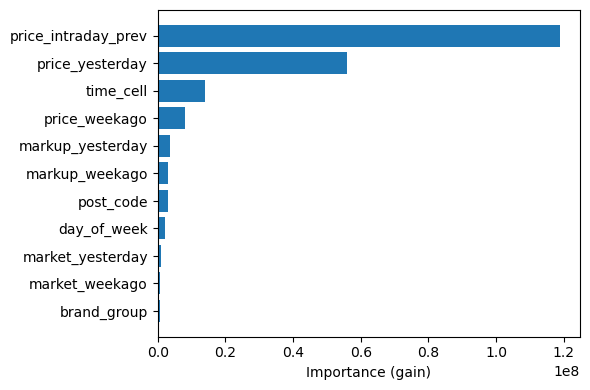

In [94]:
# Feature importances
import matplotlib.pyplot as plt

importances = gbm.feature_importance(importance_type="gain")
for col, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
    print(f"{col:15s} {imp:.1f}")

# Simple bar plot
plt.figure(figsize=(6, 4))
order = np.argsort(importances)
plt.barh(np.array(feature_cols)[order], importances[order])
plt.xlabel("Importance (gain)")
plt.tight_layout()
plt.show()

In [95]:
# Save model to disk for later use
model_path = BASE_DIR / "derived" / "lightgbm_berlin_e5_mae.txt"
gbm.save_model(model_path.as_posix())
print(f"Saved LightGBM model to: {model_path}")

Saved LightGBM model to: C:\Users\websi\OneDrive - UT Cloud\Semester\3. WS2025_26\DS500 Data Science Project (12 ECTS)\tankerkoenig_repo\tankerkoenig-data\derived\lightgbm_berlin_e5_mae.txt
